# Import Library

In [643]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor


First, we need to consider how the fare amount is calculated for yellow taxis in NYC. According to the NYC Taxi Commission (https://www.nyc.gov/site/tlc/passengers/taxi-fare.page), the standard metered fare is as follows:
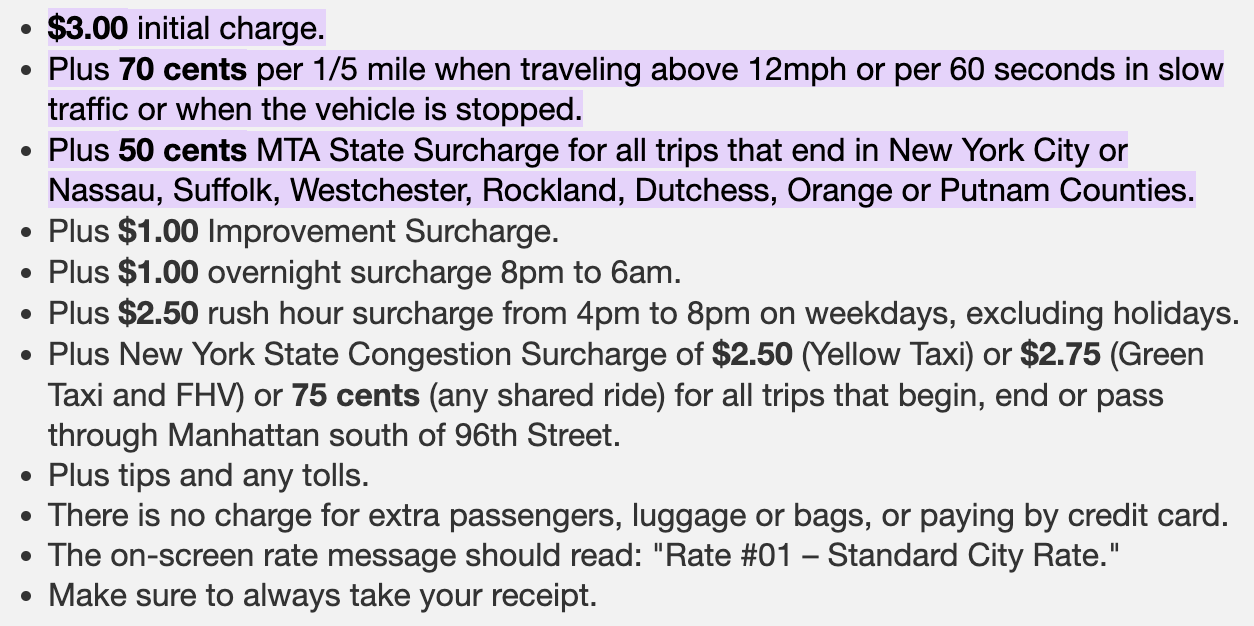


# Read Data

Load the csv into a pandas dataframe

In [644]:
df = pd.read_csv('nyc_taxi_hw.csv')

Quick check on data types and possible null values

In [645]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         100000 non-null  int64  
 1   key                100000 non-null  object 
 2   fare_amount        100000 non-null  float64
 3   pickup_datetime    100000 non-null  object 
 4   pickup_longitude   100000 non-null  float64
 5   pickup_latitude    100000 non-null  float64
 6   dropoff_longitude  100000 non-null  float64
 7   dropoff_latitude   100000 non-null  float64
 8   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 6.9+ MB


Take a look at some rows from the dataframe

In [646]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [647]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,49999.500000,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,28867.657797,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,0.000000,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,24999.750000,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,49999.500000,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,74999.250000,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,99999.000000,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


# Data Cleansing


The 'Unnamed: 0' and 'key' columns will be removed as they are redundant

In [648]:
df = df.drop(columns=['Unnamed: 0'], axis=1)
df = df.drop(columns=['key'], axis=1)

In [649]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        100000 non-null  float64
 1   pickup_datetime    100000 non-null  object 
 2   pickup_longitude   100000 non-null  float64
 3   pickup_latitude    100000 non-null  float64
 4   dropoff_longitude  100000 non-null  float64
 5   dropoff_latitude   100000 non-null  float64
 6   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 5.3+ MB


Missing Values

In [650]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

No missing values

Check for duplicates

In [651]:
duplicados = df.duplicated()
num_duplicados = duplicados.sum()

if num_duplicados > 0:
    print("Se encontraron duplicados")
    filas_duplicadas = df[duplicados]
    print(filas_duplicadas)
else:
    print("No duplicates")

No duplicates


In [652]:
def verificar_ceros(df):
    print("columna              conteo     porcentaje")
    for col in df.columns:
        if df[col].dtype != 'object':
            cnt = df[df[col] == 0].shape[0]
        else:
            cnt = df[df[col] == ''].shape[0]
        print(f"{col:<25}{cnt:<10}{round(cnt/df.shape[0]*100, 2):<5}")

verificar_ceros(df)

columna              conteo     porcentaje
fare_amount              3         0.0  
pickup_datetime          0         0.0  
pickup_longitude         1922      1.92 
pickup_latitude          1919      1.92 
dropoff_longitude        1916      1.92 
dropoff_latitude         1909      1.91 
passenger_count          366       0.37 


The percentage of records with an invalid passenger_count number and fare_amount value is relatively low, so we proceed to remove those values. In both cases, having 0 passengers and $0 fare_amount wouldn't make sense. We'll also remove the zero values in pickup_longitude, pickup_latitude, dropoff_longitude, and dropoff_latitude as those coordinates do not represent valid locations.

In [653]:
print(df.shape[0])

100000


In [654]:
df = df[df['passenger_count'] != 0]
df = df[df['fare_amount'] != 0]
verificar_ceros(df)

columna              conteo     porcentaje
fare_amount              0         0.0  
pickup_datetime          0         0.0  
pickup_longitude         1916      1.92 
pickup_latitude          1913      1.92 
dropoff_longitude        1910      1.92 
dropoff_latitude         1903      1.91 
passenger_count          0         0.0  


In [655]:
print(df.shape[0])

99631


First, let's try to understand where the coordinates of 0 are coming from

In [656]:
pickup_longitude_cero = df[df['pickup_longitude'] == 0]
pickup_latitude_cero = df[df['pickup_latitude'] == 0]
dropoff_longitude_cero = df[df['dropoff_longitude'] == 0]
dropoff_latitude_cero = df[df['dropoff_latitude'] == 0]

print("Registros con valores de cero en pickup_longitude:")
print(pickup_longitude_cero)

print("\nRegistros con valores de cero en pickup_latitude:")
print(pickup_latitude_cero)

print("\nRegistros con valores de cero en dropoff_longitude:")
print(dropoff_longitude_cero)

print("\nRegistros con valores de cero en dropoff_latitude:")
print(dropoff_latitude_cero)


Registros con valores de cero en pickup_longitude:
       fare_amount          pickup_datetime  pickup_longitude  \
11             5.5  2012-12-24 11:24:00 UTC               0.0   
15             5.0  2013-11-23 12:57:00 UTC               0.0   
26             6.5  2011-02-07 20:01:00 UTC               0.0   
124            8.0  2013-01-17 17:22:00 UTC               0.0   
192            3.7  2010-09-05 17:08:00 UTC               0.0   
...            ...                      ...               ...   
99619         10.6  2009-02-08 01:27:22 UTC               0.0   
99768          6.0  2015-06-15 03:49:16 UTC               0.0   
99829         24.9  2012-04-01 17:02:00 UTC               0.0   
99904          6.9  2010-08-14 17:56:04 UTC               0.0   
99971          6.1  2011-01-28 21:12:00 UTC               0.0   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
11                 0.0                0.0               0.0                3  
15        

In [657]:
df[df['pickup_longitude'] == 0].head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
11,5.5,2012-12-24 11:24:00 UTC,0.0,0.0,0.0,0.0,3
15,5.0,2013-11-23 12:57:00 UTC,0.0,0.0,0.0,0.0,1
26,6.5,2011-02-07 20:01:00 UTC,0.0,0.0,0.0,0.0,1
124,8.0,2013-01-17 17:22:00 UTC,0.0,0.0,0.0,0.0,2
192,3.7,2010-09-05 17:08:00 UTC,0.0,0.0,0.0,0.0,5


Since we don't have information about specific locations, we can't determine where those values come from. However, coordinates with values of 0,0 are far away from NYC, so we'll remove them.

In [658]:
df = df[df['pickup_longitude'] != 0]
df = df[df['pickup_latitude'] != 0]
df = df[df['dropoff_longitude'] != 0]
df = df[df['dropoff_latitude'] != 0]
verificar_ceros(df)

columna              conteo     porcentaje
fare_amount              0         0.0  
pickup_datetime          0         0.0  
pickup_longitude         0         0.0  
pickup_latitude          0         0.0  
dropoff_longitude        0         0.0  
dropoff_latitude         0         0.0  
passenger_count          0         0.0  


In [659]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97633 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        97633 non-null  float64
 1   pickup_datetime    97633 non-null  object 
 2   pickup_longitude   97633 non-null  float64
 3   pickup_latitude    97633 non-null  float64
 4   dropoff_longitude  97633 non-null  float64
 5   dropoff_latitude   97633 non-null  float64
 6   passenger_count    97633 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 6.0+ MB


Now, we also need to consider that the minimum fare amount in NYC is $3.00, so we should remove values below that, as well as any negative values.

In [660]:
fare_negativo = df[df['fare_amount'] < 3]
print(fare_negativo)
cantidad_fare_negativo = fare_negativo.shape[0]

print("Valores:", cantidad_fare_negativo)

       fare_amount          pickup_datetime  pickup_longitude  \
226            2.5  2012-03-29 03:51:00 UTC        -73.989142   
503            2.5  2010-01-19 01:10:00 UTC        -73.998720   
551            2.9  2011-04-22 09:02:09 UTC        -73.964774   
630            2.9  2009-01-10 16:28:00 UTC        -73.977417   
657            2.5  2009-08-25 01:50:21 UTC        -73.986410   
...            ...                      ...               ...   
99097          2.5  2012-12-31 08:17:07 UTC        -73.901842   
99210          2.9  2011-09-21 14:39:00 UTC        -73.981248   
99362          2.5  2009-10-03 06:20:59 UTC        -73.988862   
99668          2.9  2009-11-04 12:33:09 UTC        -73.986902   
99682          2.5  2013-03-16 19:44:32 UTC        -73.995396   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
226          40.720105         -73.988777         40.720662                1  
503          40.624708         -73.998720         40.624708  

In [661]:
df = df[df['fare_amount'] > 3]

In [662]:
fare_negativo = df[df['fare_amount'] < 3]
print(fare_negativo)
cantidad_fare_negativo = fare_negativo.shape[0]

print("Valores:", cantidad_fare_negativo)

Empty DataFrame
Columns: [fare_amount, pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count]
Index: []
Valores: 0



We have successfully removed all values with negative fares and fares lower than the minimum fare.

Below, reasonable ranges for longitude and latitude values for a taxi trip analysis in New York City and its surroundings will be considered.

Longitude: The longitude range between -75 and -70 covers not only New York City but also surrounding areas such as parts of New Jersey, Long Island, and possibly other nearby cities.

Latitude: The latitude range between 40.5 and 45 is suitable for New York City and its surroundings, vertically covering the entire city and adjacent areas without extending too far north.

In [663]:
longitud_min = -75
longitud_max = -70
latitud_min = 40.5
latitud_max = 45

pickup_fuera_rango = (df['pickup_longitude'] < longitud_min) | (df['pickup_longitude'] > longitud_max) | \
                     (df['pickup_latitude'] < latitud_min) | (df['pickup_latitude'] > latitud_max)

dropoff_fuera_rango = (df['dropoff_longitude'] < longitud_min) | (df['dropoff_longitude'] > longitud_max) | \
                      (df['dropoff_latitude'] < latitud_min) | (df['dropoff_latitude'] > latitud_max)

print("Registros de pickup fuera del rango razonable:")
print(df[pickup_fuera_rango])


print("\nRegistros de dropoff fuera del rango razonable:")
print(df[dropoff_fuera_rango])

df = df[~(pickup_fuera_rango | dropoff_fuera_rango)]

print("\nDataFrame después de eliminar registros fuera del rango:")
print(df)



Registros de pickup fuera del rango razonable:
       fare_amount          pickup_datetime  pickup_longitude  \
1181          25.0  2012-10-11 00:21:00 UTC         -0.004093   
2147           5.0  2013-05-24 14:54:00 UTC         40.751582   
3827          11.0  2013-06-20 04:28:00 UTC         40.719830   
4783           6.5  2013-05-22 06:28:00 UTC         40.748262   
5686           3.3  2011-07-30 11:15:00 UTC        -73.947235   
...            ...                      ...               ...   
98000          5.7  2011-10-16 19:39:00 UTC         -0.000853   
98127          8.0  2013-05-23 07:07:00 UTC         40.787575   
98360          8.9  2012-07-13 17:01:00 UTC         -1.383332   
98652         10.5  2011-05-03 07:45:00 UTC        -78.083332   
99532          8.9  2012-06-25 18:44:00 UTC        -73.978523   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
1181          0.033500           0.016852          0.017980                2  
2147        -7

Let's verify that the removal was done correctly:

In [664]:
pickup_fuera_rango = (df['pickup_longitude'] < longitud_min) | (df['pickup_longitude'] > longitud_max) | \
                     (df['pickup_latitude'] < latitud_min) | (df['pickup_latitude'] > latitud_max)

dropoff_fuera_rango = (df['dropoff_longitude'] < longitud_min) | (df['dropoff_longitude'] > longitud_max) | \
                      (df['dropoff_latitude'] < latitud_min) | (df['dropoff_latitude'] > latitud_max)

print(df[pickup_fuera_rango])
print(df[dropoff_fuera_rango])

Empty DataFrame
Columns: [fare_amount, pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count]
Index: []
Empty DataFrame
Columns: [fare_amount, pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count]
Index: []


In [665]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,96745.000000,96745.000000,96745.000000,96745.000000,96745.000000,96745.000000
mean,11.419720,-73.975091,40.751297,-73.974006,40.751679,1.682268
std,9.700281,0.039200,0.032318,0.038367,0.034599,1.299765
min,3.300000,-74.711648,40.500046,-74.895028,40.500046,1.000000
25%,6.000000,-73.992272,40.736685,-73.991395,40.735786,1.000000
50%,8.500000,-73.982086,40.753544,-73.980443,40.753980,1.000000
75%,12.500000,-73.968351,40.767685,-73.965192,40.768484,2.000000
max,200.000000,-72.856968,43.183332,-72.854940,43.415190,6.000000


Now that we've finished cleaning the data, we can use the existing data to create improved datasets.

#EDA


In [666]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [667]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
df['hour'] = df['pickup_datetime'].dt.hour
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 96745 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   fare_amount        96745 non-null  float64            
 1   pickup_datetime    96745 non-null  datetime64[ns, UTC]
 2   pickup_longitude   96745 non-null  float64            
 3   pickup_latitude    96745 non-null  float64            
 4   dropoff_longitude  96745 non-null  float64            
 5   dropoff_latitude   96745 non-null  float64            
 6   passenger_count    96745 non-null  int64              
 7   year               96745 non-null  int32              
 8   month              96745 non-null  int32              
 9   day_of_week        96745 non-null  object             
 10  hour               96745 non-null  int32              
dtypes: datetime64[ns, UTC](1), float64(5), int32(3), int64(1), object(1)
memory usage: 9.8+ MB
None


In [668]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,Monday,17
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,Tuesday,16
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,Thursday,0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,Saturday,4
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,Tuesday,7


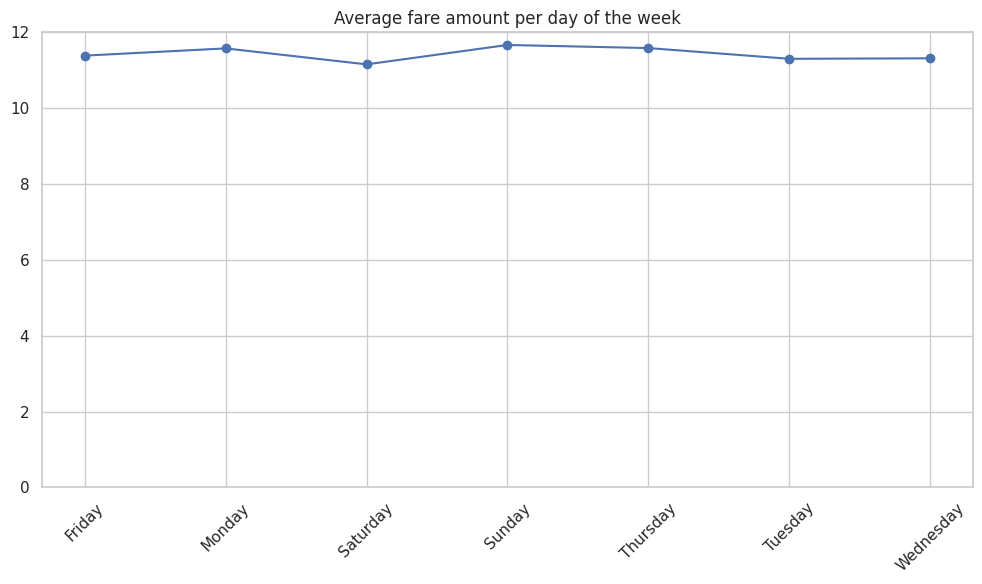

In [669]:
average_fare = df.groupby('day_of_week')['fare_amount'].mean().reset_index()
days_of_week = average_fare['day_of_week']
fare_amounts = average_fare['fare_amount']

plt.figure(figsize=(10, 6))
plt.plot(days_of_week, fare_amounts, marker='o', linestyle='-')
plt.ylim(0, 12)
plt.title('Average fare amount per day of the week')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



We cannot reach a conclusion based on this since the fare_amount is a random variable, and we need to consider additional factors to make a statement.

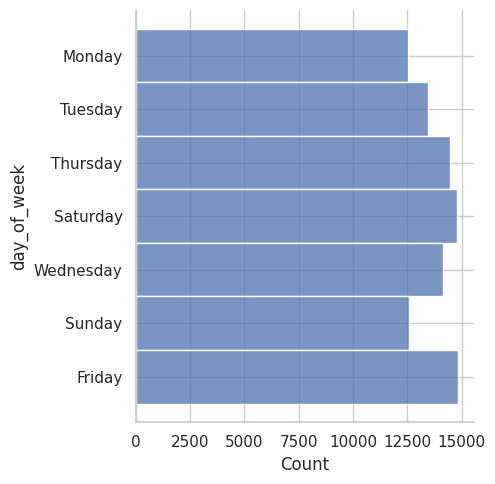

In [670]:
sns.displot(data = df, y='day_of_week')

We can observe that there is more demand on Fridays and Saturdays. This could be because people go out of their homes to engage in various activities.


To calculate the distance between two locations, we must account for the curvature of the Earth to obtain a more accurate representation. That's why I decided to use the Haversine formula to calculate the distance traveled by each taxi. Here's the process:

In [671]:
def haversine_distance(lon1, lat1, lon2, lat2):

    # Radio de la Tierra en kilómetros
    R = 6371.0

    # Convertir coordenadas de grados a radianes
    lon1_rad = np.radians(lon1)
    lat1_rad = np.radians(lat1)
    lon2_rad = np.radians(lon2)
    lat2_rad = np.radians(lat2)

    # Diferencia de coordenadas
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    # Calcular la distancia
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

df['distancia'] = haversine_distance(df['pickup_longitude'], df['pickup_latitude'],
                                      df['dropoff_longitude'], df['dropoff_latitude'])

df.head()


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,distancia
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,Monday,17,1.030764
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,Tuesday,16,8.450134
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,Thursday,0,1.389525
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,Saturday,4,2.799270
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,Tuesday,7,1.999157


In [672]:
distancia_cero = df[df['distancia'] == 0]
porcentaje_distancia_cero = (len(distancia_cero) / len(df)) * 100
print(distancia_cero.head())
print("Porcentaje de distancias con valor cero:", porcentaje_distancia_cero)


     fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
105         52.0 2009-03-25 00:08:52+00:00        -74.035839        40.747320   
191          6.5 2014-01-08 21:55:58+00:00        -73.998488        40.726303   
270          7.5 2012-08-25 01:53:42+00:00        -73.995892        40.746454   
290          6.9 2009-12-14 12:33:00+00:00        -73.982432        40.745747   
396         12.0 2014-03-12 18:12:44+00:00        -73.844904        40.736318   

     dropoff_longitude  dropoff_latitude  passenger_count  year  month  \
105         -74.035839         40.747320                1  2009      3   
191         -73.998488         40.726303                1  2014      1   
270         -73.995892         40.746454                1  2012      8   
290         -73.982432         40.745747                1  2009     12   
396         -73.844904         40.736318                1  2014      3   

    day_of_week  hour  distancia  
105   Wednesday     0        0.0 

It seems that entries with a zero distance may be anomalies in the data, as it's unlikely for a trip to have a zero distance but a significant fare_amount. Since they represent only 0.99% of the dataset, removing these entries shouldn't significantly affect the overall analysis.

In [673]:
df = df[df['distancia'] != 0]

In [674]:
distancia_cero = df[df['distancia'] == 0]
porcentaje_distancia_cero = (len(distancia_cero) / len(df)) * 100
print(distancia_cero.head())

Empty DataFrame
Columns: [fare_amount, pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count, year, month, day_of_week, hour, distancia]
Index: []


In [675]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,hour,distancia
count,95781.000000,95781.000000,95781.000000,95781.000000,95781.000000,95781.000000,95781.000000,95781.000000,95781.000000,95781.000000
mean,11.411056,-73.975405,40.751179,-73.974309,40.751566,1.682536,2011.750514,6.265616,13.498961,3.401099
std,9.604074,0.036843,0.030770,0.035956,0.033181,1.300031,1.872642,3.451843,6.503207,3.933868
min,3.300000,-74.711648,40.509960,-74.895028,40.505648,1.000000,2009.000000,1.000000,0.000000,0.000084
25%,6.100000,-73.992292,40.736697,-73.991407,40.735793,1.000000,2010.000000,3.000000,9.000000,1.294794
50%,8.500000,-73.982108,40.753550,-73.980466,40.753989,1.000000,2012.000000,6.000000,14.000000,2.196964
75%,12.500000,-73.968472,40.767672,-73.965353,40.768483,2.000000,2013.000000,9.000000,19.000000,3.980521
max,200.000000,-72.856968,43.183332,-72.854940,43.415190,6.000000,2015.000000,12.000000,23.000000,270.597736


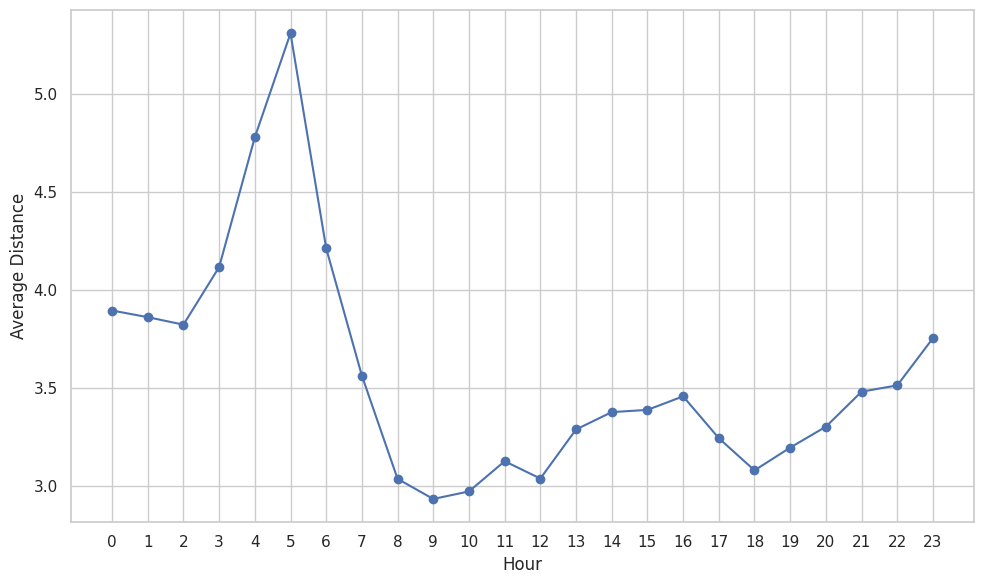

In [676]:
distance_by_hour = df.groupby('hour')['distancia'].mean()
plt.figure(figsize=(10, 6))
plt.plot(distance_by_hour.index, distance_by_hour.values, marker='o', linestyle='-')
plt.xlabel('Hour')
plt.ylabel('Average Distance')
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()

The peak in average distance at 5 a.m. is likely due to individuals heading to the airport, as they often depart very early in the morning, resulting in longer distances traveled.

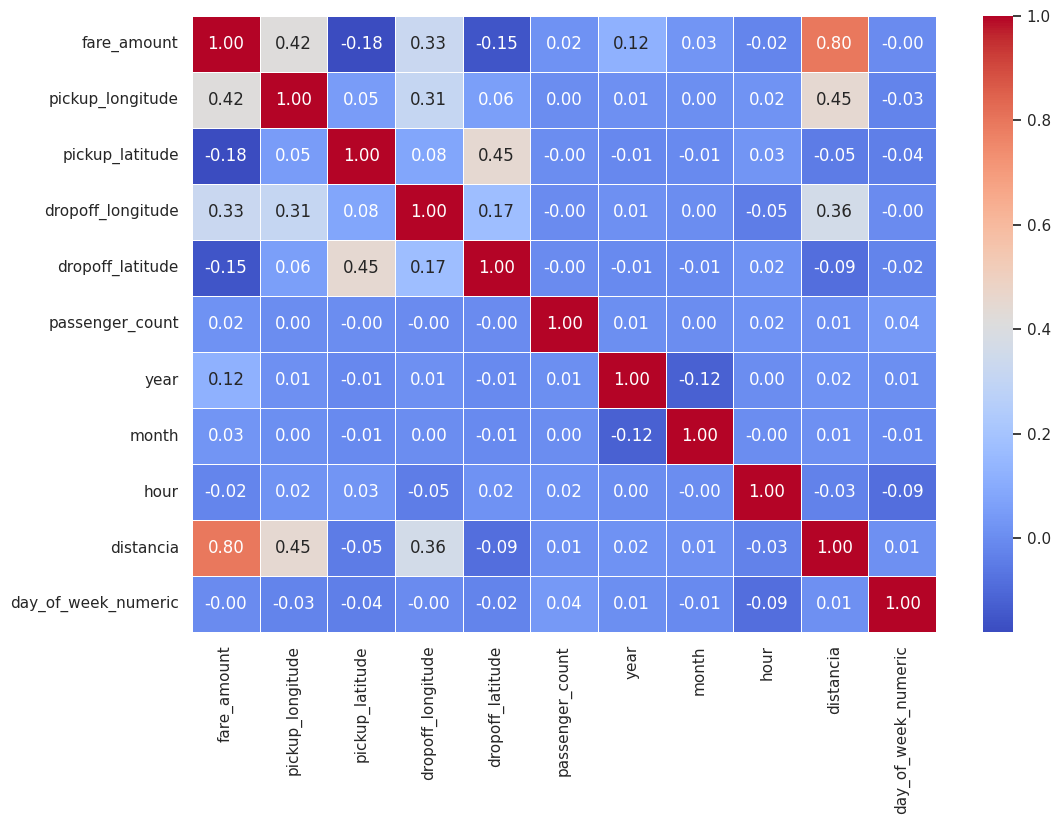

In [677]:
day_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

df['day_of_week_numeric'] = df['day_of_week'].map(day_mapping)

numeric_df = df.select_dtypes(include=['number'])

correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()




We can observe a high correlation of 0.80 between distance and fare_amount, which makes sense since the fare_amount is calculated based on the distance traveled.

<ipython-input-678-d8f5dec5308c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trips_per_hour.index, y=trips_per_hour.values, palette=colors)


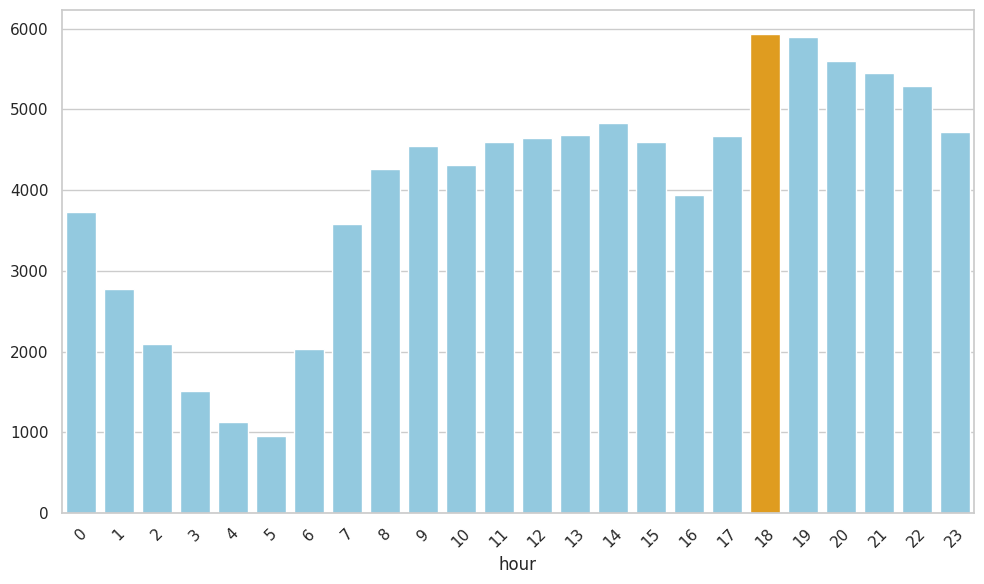

In [678]:
trips_per_hour = df['hour'].value_counts().sort_index()
max_hour = trips_per_hour.idxmax()
colors = ['skyblue' if hour != max_hour else 'orange' for hour in trips_per_hour.index]
plt.figure(figsize=(10, 6))
sns.barplot(x=trips_per_hour.index, y=trips_per_hour.values, palette=colors)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We can observe that 6:00 PM is one of the peak hours in demand, possibly because many people leave work around that time. The busiest hours are between 6:00 and 10:00 PM, when people are typically engaged in activities other than work.

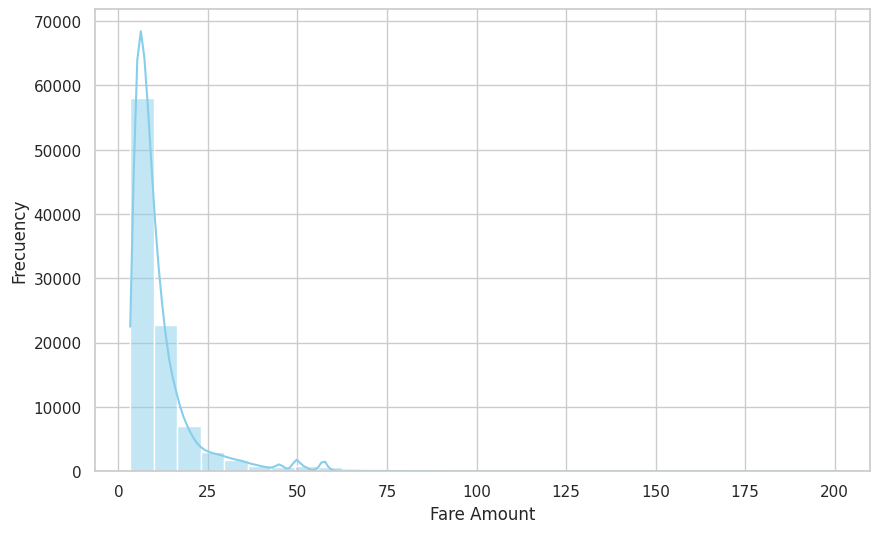

In [679]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='fare_amount', bins=30, kde=True, color='skyblue')
plt.xlabel('Fare Amount')
plt.ylabel('Frecuency')
plt.show()


The fare amount is approximately between 15 and 20 dollars.

#Train


In [680]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95781 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   fare_amount          95781 non-null  float64            
 1   pickup_datetime      95781 non-null  datetime64[ns, UTC]
 2   pickup_longitude     95781 non-null  float64            
 3   pickup_latitude      95781 non-null  float64            
 4   dropoff_longitude    95781 non-null  float64            
 5   dropoff_latitude     95781 non-null  float64            
 6   passenger_count      95781 non-null  int64              
 7   year                 95781 non-null  int32              
 8   month                95781 non-null  int32              
 9   day_of_week          95781 non-null  object             
 10  hour                 95781 non-null  int32              
 11  distancia            95781 non-null  float64            
 12  day_of_week_numeric  95

In [681]:
X = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour','distancia']]
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)


MSE: 41.78634983189632
MAE: 2.563164687573823
R2: 0.5399927134112554


Let's use neural networks to improve the prediction.

In [682]:
mlp = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=250, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)


mlp_mse = mean_squared_error(y_test, y_pred_mlp)
mlp_mae = mean_absolute_error(y_test, y_pred_mlp)
mlp_r2 = r2_score(y_test, y_pred_mlp)


print("MLPRegressor MSE:", mlp_mse)
print("MLPRegressor MAE:", mlp_mae)
print("MLPRegressor R2:", mlp_r2)


MLPRegressor MSE: 21.78331149963246
MLPRegressor MAE: 2.265034940338693
MLPRegressor R2: 0.7601972400993374


We can see that we improved the prediction using neural networks, although our linear model was not bad. We decreased from an absolute fare error of 2.56 to 2.26, which is completely acceptable.

# Recommendations

I recommend including crucial missing data for a more comprehensive analysis. For instance, the trip duration could have facilitated fare_amount calculation and provided insight into the fare calculation formula being used. Additionally, other useful data such as pick-up and drop-off locations could have been included to assess the validity of the coordinates. The arrival time is another valuable missing piece of information. It would have been beneficial to include tips for each trip as well, providing a more holistic understanding of the dataset.